In [14]:
#import libraries
import numpy as np
from datetime import datetime

from Project_functions import get_raobs, select_press

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot
from metpy.interpolate import interpolate_to_grid, remove_nan_observations

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [15]:
#grab data from Dec 27 2022
dt = datetime(2022,12,27,00)

#use get_raobs function data from Iowa State Upper Air
data = get_raobs(dt)


HTTPError: Error accessing http://mesonet.agron.iastate.edu/json/raob.py?ts=202212270000
Server Error (422: [{'type': 'missing', 'loc': ('query', 'station'), 'msg': 'Field required', 'input': {'ts': '202212270000'}, 'url': 'https://errors.pydantic.dev/2.7/v/missing'}])

In [4]:
#subset data to 500 Mb level
#using select_press function
data_500 = select_press(data, 500)


NameError: name 'data' is not defined

In [10]:
#convert the data to x, y, and z locations on the projected map
x,y,z = proj.transform_points(ccrs.PlateCarree(), data_500['longitude'].values, data_500['latitude'].values).T

#remove nans
mask = ~np.isnan(x)

#interpolate the data to a grid
grdx, grdy, hght = interpolate_to_grid(x[mask], y[mask], data_500['height'].values[mask], 
                                       interp_type = 'cressman', search_radius=1000000, 
                                       minimum_neighbors=3, hres=100000)

NameError: name 'proj' is not defined

NameError: name 'data_500' is not defined

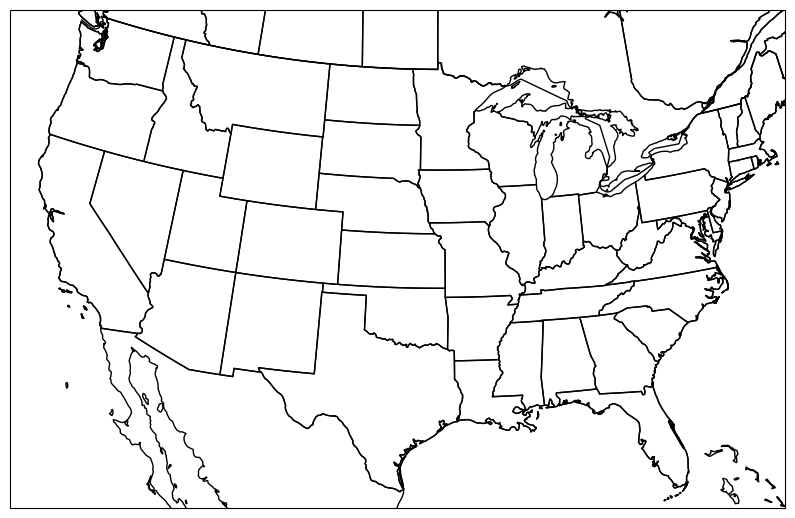

In [12]:
#create figure
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35)
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1,projection=proj)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.set_extent((-120, -75, 23, 50))

#create station plots using lat and long
stationplots = StationPlot(ax, data_500.longitude, data_500.latitude, transform = ccrs.PlateCarree(), clip_on = True,
                          fontsize = 9)

#temperature in red
stationplots.plot_parameter((-1,1), data_500['temperature'].values, color='red')

#dewpoint DEPRESSION in dark green
stationplots.plot_parameter((-1,-1), data_500['dewpoint'].values, color='darkgreen')

#height (need to format to be the first 3 digits)
stationplots.plot_parameter((1,1), data_500['height'].values, color = 'black',formatter=lambda p: format(p, '.0f')[:-1])

#station ID in dark blue
stationplots.plot_text((1.5,-1), data_500['station'], color='darkblue')

#wind in black
stationplots.plot_barb(data_500['u_wind'].values, data_500['v_wind'].values)

#plot contours from 4600m to 6000m with 60m interval
clevs = np.arange(4600, 6000, 30)
cs = ax.contour(grdx, grdy, hght, clevs, colors='black')
ax.clabel(cs, inline = True,zorder=10, fmt=lambda p: format(p, '.0f')[:-1] )

#add a title with the date
plt.title(f'{dt.strftime("%y-%m-%d %HZ")}\n500MB ANALYSIS')

#save the map as contour_500.png
plt.savefig('UpperAir_Dec_27.png', bbox_inches = 'tight')